<a href="https://colab.research.google.com/github/bimarshak7/yoga-pose-classification/blob/main/Yoga_(small).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Yoga Poses Classification

https://www.kaggle.com/datasets/niharika41298/yoga-poses-dataset

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#snippet to mount drive and copy kaggle API keys
from google.colab import drive
drive.mount('/gdrive')
! mkdir ~/.kaggle
!cp "/gdrive/MyDrive/Colab Notebooks/kaggle.json" ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

Mounted at /gdrive


In [ ]:
!kaggle datasets download -d niharika41298/yoga-poses-dataset
!unzip -q *.zip

 98% 281M/288M [00:07<00:00, 58.6MB/s]
100% 288M/288M [00:07<00:00, 38.9MB/s]


In [ ]:
%ls

DATASET/  sample_data/  yoga-poses-dataset.zip


In [ ]:
train_dir = 'DATASET/TRAIN'
test_dir = 'DATASET/TEST'

In [ ]:
import os
print("Images of each category in train directory")
for root, dirs, files in os.walk("DATASET/TRAIN"):
  print(f"There are {len(files)} images in '{root}'.")

print("\nImages of each category in test directory")
for root, dirs, files in os.walk("DATASET/TEST"):
  print(f"There are {len(files)} images in '{root}'.")

Images of each category in train directory
There are 0 images in 'DATASET/TRAIN'.
There are 223 images in 'DATASET/TRAIN/downdog'.
There are 252 images in 'DATASET/TRAIN/warrior2'.
There are 160 images in 'DATASET/TRAIN/tree'.
There are 180 images in 'DATASET/TRAIN/goddess'.
There are 266 images in 'DATASET/TRAIN/plank'.

Images of each category in test directory
There are 0 images in 'DATASET/TEST'.
There are 97 images in 'DATASET/TEST/downdog'.
There are 109 images in 'DATASET/TEST/warrior2'.
There are 69 images in 'DATASET/TEST/tree'.
There are 80 images in 'DATASET/TEST/goddess'.
There are 115 images in 'DATASET/TEST/plank'.


In [ ]:
#get array of labels
import pathlib

data_dir = pathlib.Path("DATASET/TRAIN")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_names

array(['downdog', 'goddess', 'plank', 'tree', 'warrior2'], dtype='<U8')

In [ ]:
train_datagen = ImageDataGenerator(width_shift_range= 0.1,
                                  horizontal_flip = True,
                                  rescale = 1./255,
                                  rotation_range = 2,
                                  validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale = 1./255,
                                 validation_split = 0.2)

In [ ]:
train_generator =  train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (224,224),
                                                    color_mode = 'rgb',
                                                    class_mode = 'categorical',
                                                    batch_size = 16,
                                                    subset = 'training',
                                                    seed=16,
                                                    shuffle=True)
validation_generator  = test_datagen.flow_from_directory(directory = test_dir,
                                                  target_size = (224,224),
                                                  color_mode = 'rgb',
                                                  seed=16,
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  shuffle=True)

Found 866 images belonging to 5 classes.
Found 92 images belonging to 5 classes.


In [ ]:
print(f"Shape of image: {train_generator.image_shape}.")
print(f"No. of classes: {len(class_names)}.")

Shape of image: (224, 224, 3).
No. of classes: 5.


In [ ]:
train_generator

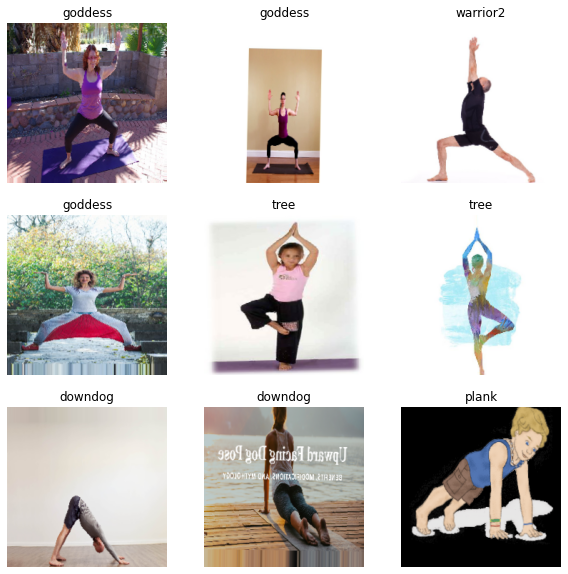

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_generator:
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")
  break

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = 'Same', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding = 'Same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu',padding = 'Same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy'])
epochs = 50  
batch_size = 16



In [ ]:
model.summary()

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
history = model.fit(train_generator, epochs = epochs,validation_data = validation_generator)

ImageDataGenerator is deprecated  
Tensorflow recommend to use image_dataset_from_directory() instead.  
So, let's do it using different approach to load dataset.

In [ ]:
#script to detect and remove defective images 
# source: https://stackoverflow.com/questions/62586443/tensorflow-error-when-trying-transfer-learning-invalid-jpeg-data-or-crop-windo

from struct import unpack
import os
    
marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}
    
class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                break        
images = []
for root,dir,img in os.walk("DATASET/"):
  for im in img:
    images.append(root+"/"+im)

bads = []
for img in images:
  image = JPEG(img) 
  try:
    image.decode()   
  except:
    bads.append(img)

print(bads)
for name in bads:
  os.remove(name)

['DATASET/TEST/downdog/00000124.jpg', 'DATASET/TEST/downdog/00000100.jpg', 'DATASET/TRAIN/tree/00000114.jpg', 'DATASET/TRAIN/tree/00000181.jpg']


In [ ]:
batch_size = 32
img_height = 300
img_width = 300
num_classes = len(class_names)

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  # subset="training",
  seed=77,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1079 files belonging to 5 classes.


In [ ]:
for img,lb in train_ds.take(1):
  print(img.shape)
  print(lb.shape)
  print(lb)
  break

(32, 300, 300, 3)
(32,)
tf.Tensor([0 4 1 0 4 4 1 1 4 4 4 4 3 2 2 3 4 1 2 1 0 4 0 3 0 2 4 2 4 2 2 2], shape=(32,), dtype=int32)


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=77,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 468 files belonging to 5 classes.


In [ ]:
data_augment = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.4,0.4)
])

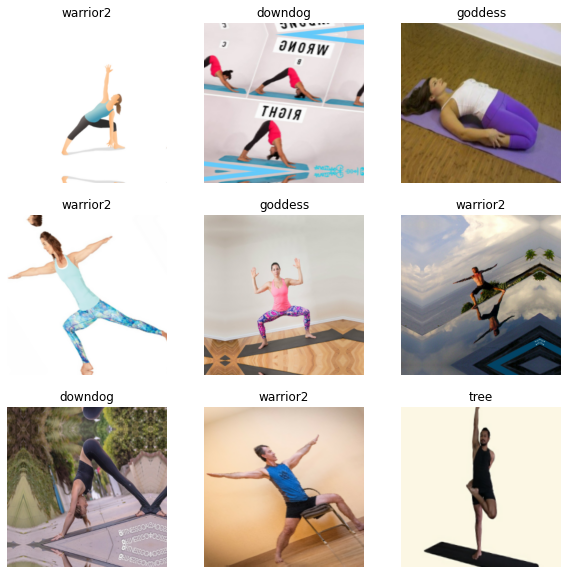

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  data = data_augment(images)
  data = tf.keras.layers.Rescaling(255,input_shape=(img_height, img_width,3))(data)

  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(data[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
aug_ds = train_ds.map(
  lambda x, y: (data_augment(x, training=True), y))

In [ ]:
train_ds = train_ds.concatenate(aug_ds)

In [ ]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = 'Same',input_shape=(img_height, img_width,3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding = 'Same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu',padding = 'Same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = optimizer,
              metrics=['accuracy'])
epochs = 150 

In [ ]:
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 300, 300, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 150, 150, 64)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 150, 150, 128)     73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 75, 75, 128)      0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 75, 75, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 256)      

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
history2 = model2.fit(train_ds, epochs = epochs,validation_data = val_ds)

Epoch 1/150
136/136 [==============================] - 2840s 21s/step - loss: 215.9655 - accuracy: 0.2593 - val_loss: 1.6070 - val_accuracy: 0.2628
Epoch 2/150
 38/136 [=======>......................] - ETA: 32:08 - loss: 1.6217 - accuracy: 0.2792

Overrrrrrrrrfitting  
Validation score saturates at 75-80%

In [ ]:
model3 = tf.keras.models.Sequential([
    data_augment,
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = 'Same'),
    tf.keras.layers.MaxPooling2D(),
    # tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding = 'Same'),
    # tf.keras.layers.MaxPooling2D(2,2),
    # tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(512, activation='relu'),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = optimizer,
              metrics=['accuracy'])
epochs = 125 

In [ ]:
history3 = model3.fit(train_ds, epochs = epochs,validation_data = val_ds)